In [2]:
import os
import itertools
import math
from time import time

import sklearn.model_selection
import torch
import torchvision

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
torch.manual_seed(0)
SKLEARN_RANDOM_SEED = 0

MAX_BYTE = 255
NUM_EPOCHS = 200
BATCH_SIZE = 12
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Extract and organize data

In [4]:
quality_ratings = ["Pasul", "A", "AA", "Muvhar"]
IMG_HEIGHT = 323
COLLAGE_COLS = 5

img_shapes = [(3,), tuple(IMG_HEIGHT*i+1 for i in [1,2,3]), (1616,)]
example_collage = torchvision.io.read_image(os.path.join("Pasul", os.listdir("Pasul")[1]))
vertical_dividers = [col for col in range(img_shapes[2][0]) if (example_collage[:,:,col] == torch.full((3, img_shapes[1][-1]), 255)).all()]
horizontal_dividers = [row for row in range(img_shapes[1][-1]) if (example_collage[:,row,:] == torch.full((3, img_shapes[2][0]), 255)).all()]

class Fruit:
    def __init__(self, serial_num, collage, camera, rating):
        self.serial_num = serial_num
        self.images = self._imgs_from_collage(collage)
        self.camera = camera
        self.quality_rating = rating

    @staticmethod
    def _imgs_from_collage(collage):
        num_img_rows = collage.shape[1] // IMG_HEIGHT
        imgs = torch.stack([
            Fruit._img_from_collage(collage, img_row, img_col)
            for img_row, img_col in itertools.product(range(num_img_rows), range(COLLAGE_COLS))
            if not (
                Fruit._img_from_collage(collage, img_row, img_col) == torch.zeros_like(Fruit._img_from_collage(collage, img_row, img_col))
            ).all()
        ])
        return imgs

    @staticmethod
    def _img_from_collage(collage, img_row, img_col):
        return collage[
            :,
            horizontal_dividers[img_row]+1 : horizontal_dividers[img_row+1], 
            vertical_dividers[img_col]+1 : vertical_dividers[img_col+1]
        ]

print("Loading images from file")
fruits = {
    quality_rating: [
        Fruit(
            serial_num=img_name[24:24+13],
            collage=torchvision.io.read_image(os.path.join(quality_rating, img_name)),
            camera=int(img_name[44:44+2]),
            rating=quality_rating
        )
        for img_name in tqdm(os.listdir(quality_rating))
    ]
    for quality_rating in quality_ratings
}  # Can be parallelized with Numba but unnecessary for small dataset provided

Loading images from file


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

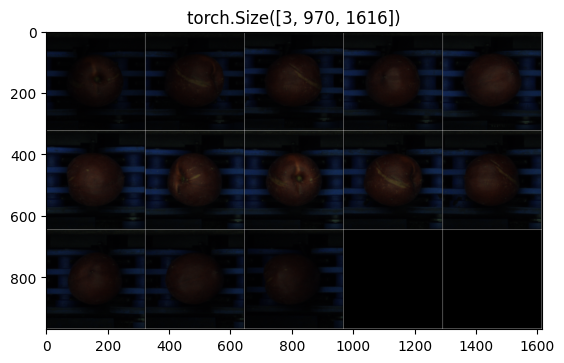

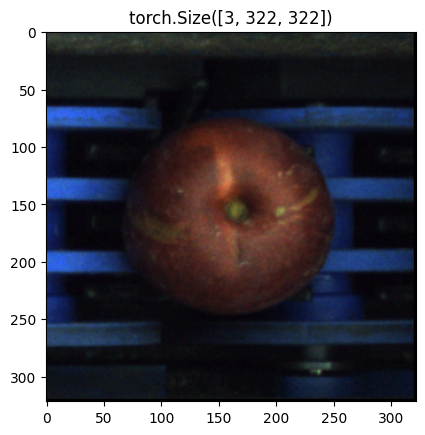

In [5]:
plt.title(example_collage.shape)
plt.imshow(example_collage.permute(1,2,0))
plt.show()

example_pasul_img = fruits["Pasul"][1].images[0]
example_pasul_img = (example_pasul_img-example_pasul_img.min())/(example_pasul_img.max()-example_pasul_img.min())
plt.title(example_pasul_img.shape)
plt.imshow(example_pasul_img.permute(1,2,0))
plt.show()

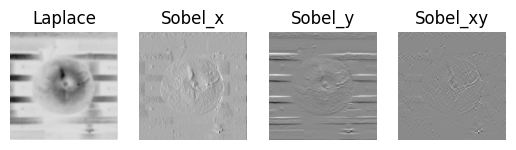

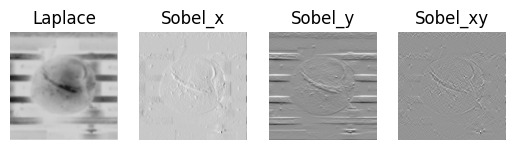

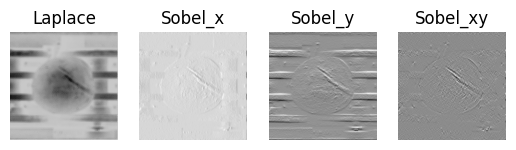

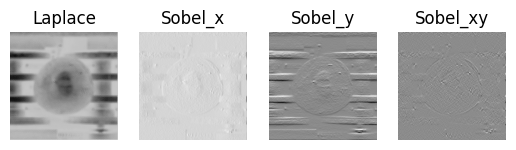

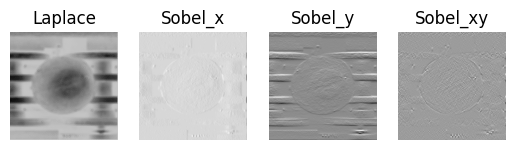

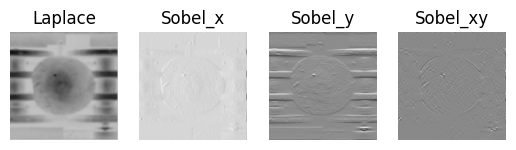

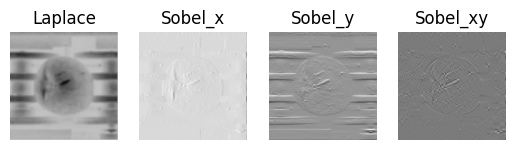

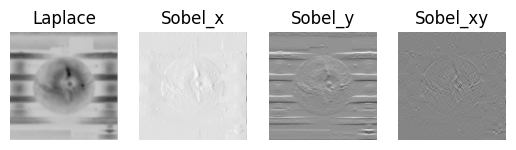

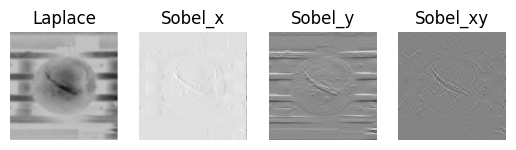

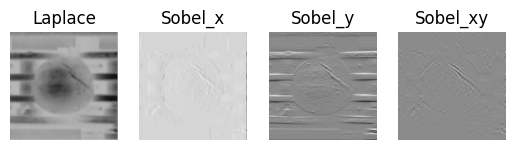

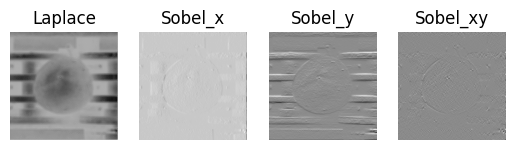

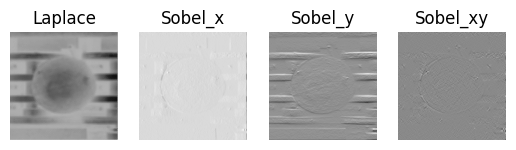

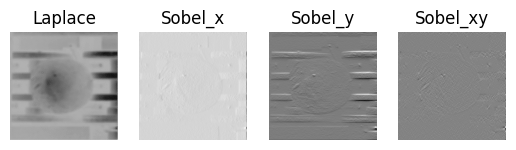

In [6]:
for example_pasul_img in fruits["Pasul"][1].images:
    example_pasul_img_channel = example_pasul_img.sum(dim=0).unsqueeze(0)/3
    laplace_filter = torch.tensor([
        [1,1,1],
        [1,-6,1],
        [1,1,1],
    ], dtype=torch.float32, device=example_pasul_img_channel.device).unsqueeze(0)
    sobely_filter = torch.tensor([
        [1,2,1],
        [0,0,0],
        [-1,-2,-1],
    ], dtype=torch.float32, device=example_pasul_img_channel.device).unsqueeze(0)
    sobelx_filter = sobely_filter.permute(0,2,1)
    
    conv_filters = torch.stack([laplace_filter, sobelx_filter, sobely_filter])
    example_filtered_pasul_img = torch.nn.functional.conv2d(example_pasul_img_channel, conv_filters)
    example_filtered_pasul_img = torch.cat([
        example_filtered_pasul_img[:, 1:-1, 1:-1],
        torch.nn.functional.conv2d(example_filtered_pasul_img[2].unsqueeze(0), sobelx_filter.unsqueeze(0))
    ], dim=0)
    
    fig, axeslist = plt.subplots(ncols=example_filtered_pasul_img.shape[0], nrows=1)
    for i, name in enumerate(["Laplace", "Sobel_x", "Sobel_y", "Sobel_xy"]):
        axeslist.ravel()[i].set_title(name)
        axeslist.ravel()[i].imshow(example_filtered_pasul_img.cpu()[i], cmap="Greys")
        axeslist.ravel()[i].set_axis_off()
    plt.show()

# Modelling

## Data

In [7]:
max_imgs_per_fruit = max([max([fruit.images.shape[0] for fruit in fruits[rating]]) for rating in quality_ratings])

In [8]:
all_fruits = list(itertools.chain.from_iterable(fruits.values()))
# all_fruits = all_fruits[:3]  # DEBUG
train_eval_fruits, test_fruits = sklearn.model_selection.train_test_split(
    all_fruits,
    random_state=SKLEARN_RANDOM_SEED
)
train_fruits, eval_fruits = sklearn.model_selection.train_test_split(
    train_eval_fruits, 
    test_size=0.1,  # Small eval set because insufficient data
    train_size=1-0.1,
    random_state=SKLEARN_RANDOM_SEED+1
)

train_ds = torch.utils.data.TensorDataset(
    torch.stack([
        torch.nn.functional.pad(  # Standardize the number of images for each fruit to max_imgs_per_fruit
            fruit.images,
            (0,0, 0,0, 0,0, 0,max_imgs_per_fruit-fruit.images.shape[0])
        )
        for fruit in train_fruits
    ]),
    torch.tensor([fruit.images.shape[0] for fruit in train_fruits]),
    torch.tensor([quality_ratings.index(fruit.quality_rating) for fruit in train_fruits])
)
eval_ds = torch.utils.data.TensorDataset(
    torch.stack([
        torch.nn.functional.pad(
            fruit.images,
            (0,0, 0,0, 0,0, 0,max_imgs_per_fruit-fruit.images.shape[0])
        )
        for fruit in eval_fruits
    ]),
    torch.tensor([fruit.images.shape[0] for fruit in eval_fruits]),
    torch.tensor([quality_ratings.index(fruit.quality_rating) for fruit in eval_fruits])
)
test_ds = torch.utils.data.TensorDataset(
    torch.stack([
        torch.nn.functional.pad(
            fruit.images,
            (0,0, 0,0, 0,0, 0,max_imgs_per_fruit-fruit.images.shape[0])
        )
        for fruit in test_fruits
    ]),
    torch.tensor([fruit.images.shape[0] for fruit in test_fruits]),
    torch.tensor([quality_ratings.index(fruit.quality_rating) for fruit in test_fruits])
)

# Images are zero-padded on the end up to the max number of images for a given fruit.
# Labels are tuples (unpadded_number_of_fruit_images, class) with 0 <= class <= 3
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = torch.utils.data.DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Model

Different fruits have different numbers of images.  How are we to represent a fruit?  A few options (in order of rising complexity) are:
- Replace the missing images with zeros (black images).  Not implemented.
- <b>Fully classify each image on its own and then take the minimal rating.</b>  This approach is a direct application of the rule that a fruit is judged by its worst POV, and is a priori probably the best implementation.
- Compute an embedding for each image, aggregate, and then classify the aggregated embedding.  This has the benefit of giving the model all possible data when considering a fruit, which can be useful for discovering a priori unknown signs of a given rating (e.g. although we would imagine at first that the only relevant signs are those on the surface of the fruit such as holes or rot, perhaps in fact the shape of the fruit can provide additional information relevant to its rating.  The shape is most easily obtained by considering multiple views of the fruit).

## Network architecture

In [9]:
class ImglayerToFruitlayer(torch.nn.Module):
        # Torchscript decorator for applying layers meant for images to collections of images (apply the layer to each image)
        def __init__(self, imglayer):
            super().__init__()
            self.imglayer = imglayer
            
        def forward(self, *batch_fruit_imgs):
            imgs_per_fruit = batch_fruit_imgs[0].shape[1]
            mixed_fruits_and_imgs = tuple(
                batch_fruit_imgs_tensor.reshape(-1, *batch_fruit_imgs_tensor.shape[2:]) 
                for batch_fruit_imgs_tensor in batch_fruit_imgs
            )
            processed_imgs = self.imglayer(*mixed_fruits_and_imgs)
            return processed_imgs.reshape(-1, imgs_per_fruit, *processed_imgs.shape[1:])

<b>Feature extraction:</b>

A visual inspection of the data suggests that some relevant features for quality classification are:
- The color histogram (rot and discoloration seems to have a distinctive color)
- The average magnitude of the photo gradients (a good fruit should have mostly gradual changes of color)
- The average curvature of curves extracted with a high-pass filter (a good fruit may have spots on it, but they should have smooth edges)

This may be complemented by deep features.  A suggested feature extractor is deformable convolutions, which will help the model attain local affine invariance (a bad sign is still bad even when rotated/rescaled).

In [10]:
class EdgeDetectionFilters(torch.nn.Module):
    laplace_filter = torch.tensor([
        [1,1,1],
        [1,-6,1],
        [1,1,1],
    ], dtype=torch.float32, device=device).unsqueeze(0)
    sobel_y_filter = torch.tensor([
        [1,2,1],
        [0,0,0],
        [-1,-2,-1],
    ], dtype=torch.float32, device=device).unsqueeze(0)
    sobel_x_filter = sobel_y_filter.transpose(1,2)
    conv_filters = torch.stack([laplace_filter, sobel_x_filter, sobel_y_filter])

    def forward(self, img_batch):
        device_img_batch = img_batch.to(device)
        bw_img_batch = (device_img_batch.sum(dim=1)/device_img_batch.shape[1]).unsqueeze(1)
        first_level_filtered = torch.nn.functional.conv2d(bw_img_batch, self.conv_filters)
        second_level_filtered = torch.nn.functional.conv2d(first_level_filtered[:,2].unsqueeze(1), self.conv_filters[1].unsqueeze(0))
        return torch.cat([first_level_filtered[:, :, 1:-1, 1:-1], second_level_filtered], dim=1).to(img_batch.device)

    @staticmethod
    def get_num_filters():
        # one laplace filter, 2 sobel filters, and one double sobel filter
        return EdgeDetectionFilters.conv_filters.shape[0] + 1

In [11]:
INPUT_IMG_SIZE = 322
class ImgQualityClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.edge_extractors = EdgeDetectionFilters()
        edge_ftr_channels = 32
        self.edge_ftr_extractor = torchvision.ops.Conv2dNormActivation(
            in_channels = self.edge_extractors.get_num_filters(), 
            out_channels = edge_ftr_channels, 
            kernel_size = 5,
            bias = True
        )
        self.edge_pool = torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False, divisor_override=1)
        edge_features_summary_shape = edge_ftr_channels, INPUT_IMG_SIZE//2-2, INPUT_IMG_SIZE//2-2

        color_ftr_channels = 16
        self.color_ftr_extractor = torchvision.ops.Conv2dNormActivation(
            in_channels = 3, 
            out_channels = color_ftr_channels, 
            kernel_size = 1,  
            bias = True
        )
        self.color_pool = torch.nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False, divisor_override=1)
        color_features_summary_shape = color_ftr_channels, INPUT_IMG_SIZE//2, INPUT_IMG_SIZE//2

        self.fusion_feature_combiner = torch.nn.Sequential(
            torchvision.ops.Conv2dNormActivation(
                in_channels = edge_ftr_channels + color_ftr_channels, 
                out_channels = 64, 
                kernel_size = 3,
                stride=2,
                bias = True
            ),
            torch.nn.AvgPool2d(kernel_size=3, stride=2),
            torchvision.models.resnet18(weights="DEFAULT").layer2
        )
        self.fusion_feature_combiner = self.fusion_feature_combiner
        self.fusion_pool = torch.nn.AvgPool2d(kernel_size=3, stride=2)
        fusion_features_summary_shape = 128, 9, 9
        
        num_features = math.prod(fusion_features_summary_shape)
        self.classifier_head = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, 4)
        )

    def forward(self, img_batch):
        edge_batch = self.edge_extractors(img_batch)  # uncomment to make the model self-contained
        edge_features = self.edge_ftr_extractor(edge_batch)
        edge_features_summary = self.edge_pool(edge_features)

        color_features = self.color_ftr_extractor(img_batch)
        color_features_summary = self.color_pool(color_features)

        # Crop instead of pad to avoid weird colors at edges
        fusion_features = self.fusion_feature_combiner(
            torch.cat([
                edge_features_summary,
                color_features_summary[:, :, 1:-1, 1:-1]
            ], dim=1)
        )
        fusion_features_summary = self.fusion_pool(fusion_features)
        
        preds = self.classifier_head(fusion_features_summary)
        return preds

In [12]:
class FruitClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.img_classifier = ImglayerToFruitlayer(ImgQualityClassifier())

    def forward(self, batch_fruit_imgs, batch_num_imgs):
        preds_per_img = self.img_classifier(batch_fruit_imgs)  # shape: batch_size x imgs_per_fruit x num_classes
        
        # overwrite rating predictions of pad images (implemented by repeating prediction of last nonpad image)
        preds_per_nonpad_img = preds_per_img.gather(  
            index=torch.min(
                torch.arange(preds_per_img.shape[1], device=preds_per_img.device)\
                    .unsqueeze(0).unsqueeze(2).expand_as(preds_per_img),
                batch_num_imgs.unsqueeze(1).unsqueeze(2) - 1  # Identity gather, clipped to last nonpad image
            ),
            dim=1
        )

        # only use worst image of fruit
        worst_img = preds_per_nonpad_img.max(dim=2).indices.min(dim=1).values
        preds_per_fruit = preds_per_nonpad_img[torch.arange(preds_per_nonpad_img.shape[0]), worst_img, :]
        return preds_per_fruit

model = FruitClassifier().to(device)
for mod_name, module in model.img_classifier.imglayer._modules.items():
    print(f"{mod_name}: {sum(param.numel() for param in module.parameters())/1000}*1000 float32 parameters")

edge_extractors: 0.0*1000 float32 parameters
edge_ftr_extractor: 3.296*1000 float32 parameters
edge_pool: 0.0*1000 float32 parameters
color_ftr_extractor: 0.096*1000 float32 parameters
color_pool: 0.0*1000 float32 parameters
fusion_feature_combiner: 553.408*1000 float32 parameters
fusion_pool: 0.0*1000 float32 parameters
classifier_head: 41.476*1000 float32 parameters


## Training architecture

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [
        {'params': model.img_classifier.imglayer.fusion_feature_combiner.parameters(), 'lr': 5e-4},
        {'params': itertools.chain(*(
            model.img_classifier.imglayer._modules[module].parameters() 
            for module in model.img_classifier.imglayer._modules
            if module != "fusion_feature_combiner"
        ))}
    ], lr=1e-2, weight_decay=1e-2) #, decoupled_weight_decay=True)

## Train loop

In [14]:
train_transforms = ImglayerToFruitlayer(
    torch.nn.Sequential(
        torchvision.transforms.Normalize(mean=0, std=1),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip()
    )
)
test_transforms = ImglayerToFruitlayer(
    torch.nn.Sequential(
        torchvision.transforms.Normalize(mean=0, std=1)
    )
)

In [15]:
def uint_to_float(uint8_img):
    return uint8_img/MAX_BYTE if uint8_img.dtype==torch.uint8 else uint8_img

def eval_model(model, eval_dl):
    total_correct = 0
    total_samples = 0
    for fruit_imgs, num_imgs, targets in eval_dl:
        fruit_imgs, num_imgs, targets = fruit_imgs.to(device), num_imgs.to(device), targets.to(device)
        fruit_imgs = uint_to_float(fruit_imgs)
        total_samples += targets.shape[0]
        fruit_imgs = test_transforms(fruit_imgs)
        preds = model(fruit_imgs, num_imgs).max(dim=1).indices
        total_correct += (targets == preds).sum()
    return total_correct / total_samples

Some transforms we would like to attain invariance to are:
- Flip (horizontal and vertical)
- Lighting change (lack of normalization)
- Rotation (since a fruit does not change its rating by being rotated)

These may be addressed with the relevant 
image augmentations

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0 completed with eval accuracy 0.321


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1 completed with eval accuracy 0.411


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2 completed with eval accuracy 0.339


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3 completed with eval accuracy 0.393


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4 completed with eval accuracy 0.464


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5 completed with eval accuracy 0.464


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6 completed with eval accuracy 0.518
Saving model


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7 completed with eval accuracy 0.464


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8 completed with eval accuracy 0.464


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9 completed with eval accuracy 0.482


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10 completed with eval accuracy 0.411


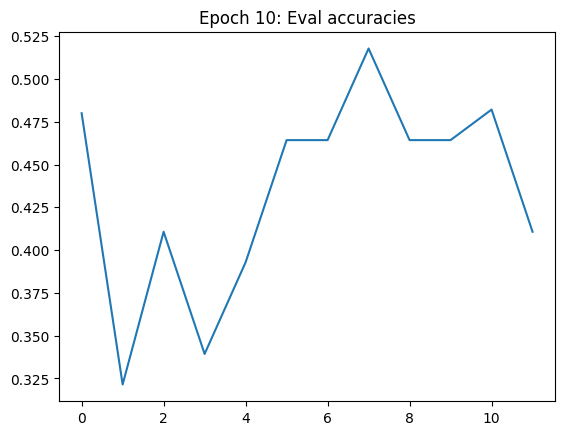

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11 completed with eval accuracy 0.482


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12 completed with eval accuracy 0.464


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13 completed with eval accuracy 0.482


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14 completed with eval accuracy 0.393


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15 completed with eval accuracy 0.482


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 16 completed with eval accuracy 0.554
Saving model


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17 completed with eval accuracy 0.357


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 18 completed with eval accuracy 0.589
Saving model


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19 completed with eval accuracy 0.5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20 completed with eval accuracy 0.446


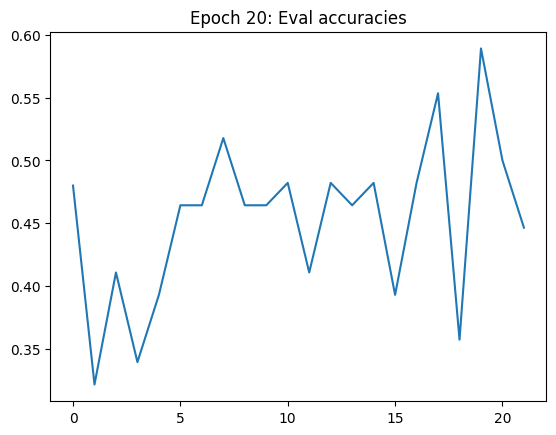

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 21 completed with eval accuracy 0.429


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 22 completed with eval accuracy 0.5


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 23 completed with eval accuracy 0.518


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 24 completed with eval accuracy 0.554


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 25 completed with eval accuracy 0.446


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 26 completed with eval accuracy 0.554


  0%|          | 0/42 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# %debug
losses, eval_accuracies = [], [0.48]
GRAPH_EVERY = 10
eval_accuracy = 0

for epoch in range(NUM_EPOCHS):
    for fruit_imgs, num_imgs, targets in (pbar := tqdm(train_dl)):
        # fruit_imgs.shape: batch_size x imgs_per_fruit x color_channels x height x width
        # times = [time()]
        fruit_imgs, num_imgs, targets = map(lambda x: x.to(device), [fruit_imgs, num_imgs, targets])
        # times.append(time())
        transformed_fruit_imgs = train_transforms(uint_to_float(fruit_imgs))
        # times.append(time())
        preds = model(transformed_fruit_imgs, num_imgs)
        # times.append(time())
        loss = loss_fn(preds, torch.nn.functional.one_hot(targets, num_classes=4).to(torch.float32))
        loss.backward()
        # times.append(time())
        optimizer.step()
        # times.append(time())
        optimizer.zero_grad()
        # times.append(time())
        cpu_loss = loss.cpu().item()
        # times.append(time())
        
        # pbar.set_description(f"Train loss: {round(cpu_loss, 3)}")
        # losses.append(cpu_loss)
        # times.append(time())

        # for i in range(len(times)-1):
        #     print(f"Time {i}: {times[i+1] - times[i]}")
        # print("\n")

    eval_accuracy = eval_model(model, eval_dl)
    print(f"Epoch {epoch} completed with eval accuracy {round(eval_accuracy.cpu().item(), 3)}")
    eval_accuracies.append(eval_accuracy.cpu().item())

    # Early stopping
    if eval_accuracy >= max(eval_accuracies):
        print("Saving model")
        with open(f"cnn_model_weights_FiltersClass_acc{round(eval_accuracy.cpu().item(), 2)}.pth", "wb") as model_save_file:
            torch.save(model, model_save_file)

    if epoch % GRAPH_EVERY == 0 and epoch != 0:
        plt.plot(eval_accuracies)
        plt.title(f"Epoch {epoch}: Eval accuracies")
        plt.show()

In [16]:
test_model = torch.load("cnn_model_weights_FiltersClass_acc0.59.pth")
test_acc = eval_model(test_model, test_dl)
test_acc

tensor(0.5484, device='mps:0')